In [52]:
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


print("libraries successfully imported and loaded")

libraries successfully imported and loaded


In [42]:
#relativ path
DATA_DIR = Path("../data/raw")
features3sec = DATA_DIR / "features_3_sec.csv"
data = pd.read_csv(features3sec)

data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [43]:
print("Number of samples:", len(data))

print("\nAll columns:")
print(data.columns.tolist())

print("\nGenres in dataset:")
print(data['filename'].str.split('.').str[0].unique())

print("\nSamples per genre:")
print(data['filename'].str.split('.').str[0].value_counts())


Number of samples: 9990

All columns:
['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label']

Genres in dataset:
['blues' 'classical' 'cou

In [44]:
#Trenger ikke filnavn og lengde - hjelper ikke modellen noe
data = data.drop(columns=['filename', 'length'])

In [45]:
#Feature scaling and encoding
#henter siste rad med alle sjangere og transformerer til tall for target label
genre_list = data.iloc[:, -1]
print(genre_list)

encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object


In [46]:
#Skalerer dataene og deler train test set
#Viktig å huske np.float array fordi bibliotekene forventer numpy arrays
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=np.float64))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#edit: lage validation set for måling av overfitting ved trening
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


print(f"Training: {len(X_train)}")
print(f"Test: {len(X_test)}")

Training: 5994
Test: 1998


In [47]:
#lager modellen
#layers.dense lager en sammenkoblet "full" layer med 512 neuronene og ReLU aktivasjon (max(0-x))
#Dropout for å regularisere modellen og hindre overfitting. Dropper 30% av neuronene
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.4), #orginalt 0,3 = overfitting, 0,5 underfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()


C:\Users\olive\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,210 (762.54 KB)

 Trainable params: 195,210 (762.54 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
#kompilerer modellen
#loss er sparse fordi y er enkelverdi tilsvarende sjanger og ikke hot one encoded i tabell
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
#Forhindrer overfitting siden første trening hadde svak overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#trener modellen
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

#får noe overfitting her

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4923 - loss: 1.3941 - val_accuracy: 0.6702 - val_loss: 0.9604
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6528 - loss: 0.9831 - val_accuracy: 0.7197 - val_loss: 0.8244
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7090 - loss: 0.8429 - val_accuracy: 0.7447 - val_loss: 0.7367
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7336 - loss: 0.7460 - val_accuracy: 0.7928 - val_loss: 0.6520
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7616 - loss: 0.6724 - val_accuracy: 0.7958 - val_loss: 0.6091
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7828 - loss: 0.6102 - val_accuracy: 0.8113 - val_loss: 0.5509
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8018 - loss: 0.5582 - val_accuracy: 0.8203 - val_loss: 0.5391
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8150 - loss: 0.5266 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


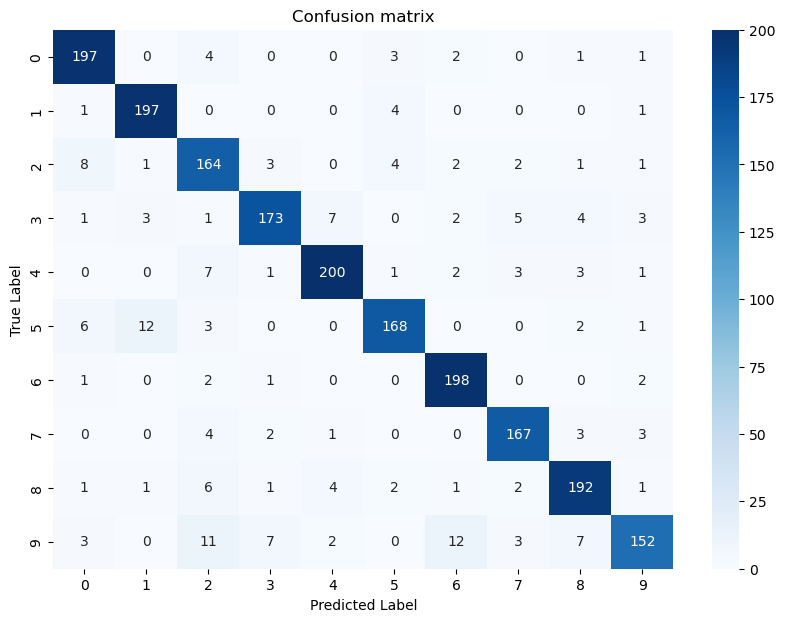

0: blues
1: classical
2: country
3: disco
4: hiphop
5: jazz
6: metal
7: pop
8: reggae
9: rock


In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

genre_names = encoder.classes_
for i, genre in enumerate(genre_names):
    print(f"{i}: {genre}")

Modell sliter med rock